In [1]:
import numpy as np
import jax.numpy as jnp
from matplotlib import pyplot as plt
import jax
from jax import grad, hessian, jit, vmap
from jax.nn import celu
import gvar as gv
from functools import partial
from IPython.display import clear_output
import jax.example_libraries.optimizers as jax_opt
from tqdm import trange
from math import factorial
import cProfile

N = 10
N_up = 5
N_down = N - N_up


FACT_UP = 1/np.sqrt(factorial(N_up))
FACT_DOWN = 1/np.sqrt(factorial(N_down))

phi_structure = [10, 20, 25, 25, 20, 10]

m = 1
hbar = 1
omega = 1
harmonic_omega = 1

# this just gets the shapes of the weights and biases for a neural network with the given structure
def gen_weight_shapes(input_size, hidden_sizes, output_size):
    weights = []
    biases = []

    if hidden_sizes != [0]:
        sizes = [input_size] + hidden_sizes + [output_size]
    else:
        sizes = [input_size, output_size]
    for i in range(len(sizes) - 1):
        w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
        b = np.random.randn(1, sizes[i+1]) 
        weights.append(w)
        biases.append(b) 
    return weights, biases

# get the shapes
weight_shapes, bias_shapes = gen_weight_shapes(N, phi_structure, 1)

# generates a set of weights and biases for a neural network with the given structure
# returns a flattened array of the parameters

def gen_params(input_size, hidden_sizes, output_size):
    weights = []
    biases = []

    if hidden_sizes != [0]:
        sizes = [input_size] + hidden_sizes + [output_size]
    else:
        sizes = [input_size, output_size]
    for i in range(len(sizes) - 1):
            w = np.random.randn(sizes[i], sizes[i+1]) * np.sqrt(2/sizes[i])
            b = np.random.randn(1, sizes[i+1]) 
            weights.append(w)
            biases.append(b)
    return flatten_params(weights, biases) 

# calls the neural network with the given parameters and input
@jit
def nn(x, params):
    weights, biases = unflatten_params(params) 
    a = x
    for i in range(len(weights) - 1):
        z = jnp.dot(a, weights[i]) + biases[i]
        a = celu(z)
    a = jnp.dot(a, weights[-1]) + biases[-1]
    return a[0][0] 

# takes the weights and biases of a network and returns a flattened array of the parameters
@jit
def flatten_params(weights, biases):
    params = jnp.array([])
    for i in range(len(weights)):
        params = jnp.concatenate((params, weights[i].flatten()))
        params = jnp.concatenate((params, biases[i].flatten()))
    return jnp.array(params)

# takes a flattened array of parameters and returns the weights and biases of the network
@jit
def unflatten_params(params):
    weights = []
    biases = []
    start = 0
    for i in range(len(weight_shapes)):
        end = start + weight_shapes[i].size 
        weights.append(jnp.reshape(jnp.array(params[start:end]), weight_shapes[i].shape))
        start = end
        end = start + bias_shapes[i].size
        biases.append(jnp.reshape(jnp.array(params[start:end]), bias_shapes[i].shape))
        start = end
    return weights, biases

# takes in coordinates, and symmetrizes the coordinates from index sym_start to index sym_end
@partial(jit, static_argnums=(1,2))
def transform(coords, sym_start, sym_end):
    C = 2
    ret = coords.copy()
    for i in range(sym_start, sym_end + 1):
        ret = ret.at[i].set(jnp.sum(jnp.power(coords/C, i + 1)))
    return ret 


network = gen_params(N, phi_structure, 1)
# the length of the flattened parameters of a single particle neural network
phi_params_length = len(network)

# function that takes the coords, and moves coords[index] to the front of the list
@partial(jit, static_argnums=(1,))
def shift_coords(coords, index):
    return jnp.concatenate([jnp.array([coords[index]]), jnp.array(coords[:index]), jnp.array(coords[index + 1:])])

@partial(jit, static_argnums=(1,))
def inputs_up(coords, j):
    reordered = shift_coords(coords, j)
    sym_piece1 = reordered[1:N_up]
    sym_piece2 = reordered[N_up:]

    C = 3.0

    new1 = []
    new2 = []
    for i in range(1, N_up):
        new1.append(sum((jnp.array(sym_piece1)/C)**i))
    for i in range(1, N_down+1):
        new2.append(sum((jnp.array(sym_piece2)/C)**i))
    
    return jnp.array([reordered[0]] + new1 + new2)

@partial(jit, static_argnums=(1,))
def inputs_down(coords, j):
    reordered = shift_coords(coords, j + N_up)
    
    sym_piece1 = reordered[1:N_up+1]
    sym_piece2 = reordered[N_up + 1:]
    
    num = 3.0
    
    new1 = []
    new2 = []
    for i in range(1, N_up+1):
        new1.append(sum((jnp.array(sym_piece1)/num)**i))
    for i in range(1, N_down):
        new2.append(sum((jnp.array(sym_piece2)/num)**i))
        
    return jnp.array([reordered[0]] + new1 + new2)

@jit
def Phi_up(coords, params):
    # construct the matrix of outputs of the neural networks
    # take only the up spin coordinates
    mat = jnp.zeros((N_up, N_up))
    for i in range(N_up):
        ith_params = params[i * phi_params_length : (i + 1) * phi_params_length]
        for j in range(N_up): 
            mat = mat.at[i,j].set(nn(inputs_up(coords, j), ith_params))
    return jnp.linalg.det(mat) * FACT_UP 

@jit
def Phi_down(coords, params):
    # construct the matrix of outputs of the neural networks
    # take only the up spin coordinates
    mat = jnp.zeros((N_down, N_down))
    for i in range(N_down):
        temp = i + N_up
        ith_params = params[temp * phi_params_length : (temp + 1) * phi_params_length]
        for j in range(N_down): 
            mat = mat.at[i,j].set(nn(inputs_down(coords, j), ith_params))
    return jnp.linalg.det(mat)* FACT_DOWN
@jit
def psi(coords, params):
    return  Phi_up(coords, params) * Phi_down(coords, params) * jnp.exp(-omega * jnp.sum(coords**2))


def sample(params, num_samples=10**3, thermalization_steps=200, skip_count=50, variation_size=1.0):
    outputs = []
    num_accepted = 0
    num_total = num_samples * skip_count + thermalization_steps + 1
    rand_coords = np.random.uniform(-variation_size, variation_size, size=(num_total, N))
    rand_accepts = np.random.uniform(0, 1, size=num_total)

    coords_t = jnp.zeros(N)
    for step in range(num_total):
        coords_t, accepted = sample_body(params, coords_t, rand_coords[step], rand_accepts[step])
        if accepted:
            num_accepted += 1
        if ((step > thermalization_steps) and (step % skip_count == 0)):
            outputs.append(coords_t)
    # create a second output array, where the second coordinate is equal to the first coordinate
    outputs_prime = outputs.copy()
    for i in range(len(outputs)):
        a = np.array(outputs[i])
        a[1] = a[0]
        outputs_prime[i] = jnp.array(a)
    return jnp.array(outputs), jnp.array(outputs_prime), num_accepted/num_total

@jit
def sample_body(params, coords_t, rand_coords, rand_accepts):
    coords_prime = coords_t + rand_coords
    return jax.lax.cond(rand_accepts < psi(coords_prime, params)**2/psi(coords_t, params)**2, lambda x,_: (x,True) , lambda _,y: (y,False), coords_prime, coords_t)


psi_hessian = jax.jacfwd(jit(grad(psi, 0)), 0) # type: ignore

@jit
def ddpsi(coords, params):
    #return jnp.diagonal(A_hessian(transform(coords), params))
    return jnp.diag(psi_hessian(coords, params))

@jit
def Hpsi(coords, params):
    return jnp.sum((m * .5 * harmonic_omega**2 * coords**2)) - hbar**2 / (2 * m) * jnp.sum(ddpsi(coords, params))/psi(coords, params)

vhpsi = jit(vmap(Hpsi, in_axes=(0, None), out_axes=0)) 

@jit
def grad_helper(coords, params):
    return jnp.sum((m*.5*omega**2*coords**2))*psi(coords, params) - hbar**2 / (2*m) * jnp.sum(ddpsi(coords, params))

vgrad_helper = jit(vmap(grad_helper, in_axes=(0, None), out_axes=0))

# derivative of the wavefunction with respect to the parameters
dnn_dtheta = jit(grad(psi, 1)) 
vdnn_dtheta = jit(vmap(dnn_dtheta, in_axes=(0, None), out_axes=0))

def grad_comp(s, params, energy_calc):
    return (1/psi(s, params) * dnn_dtheta(s, params)) * (1/psi(s, params)*grad_helper(s, params) - energy_calc) 

vgrad_comp = vmap(grad_comp, in_axes=(0, None, None), out_axes = 0)

def gradient(params, num_samples=10**3, thermal=200, skip=50, variation_size=1.0):
    # first sample
    samples, _, _ = sample(params, num_samples, thermal, skip, variation_size)
    # compute the energy 
    psiHpsi = vhpsi(samples, params) 
    energy_calc = 1/num_samples * jnp.sum(psiHpsi)
    # compute the uncertainty in the energy
    uncert = jnp.std(psiHpsi)/jnp.sqrt(num_samples) 

    # gradient computation
    grads = vgrad_comp(samples, params, energy_calc)
    gradient_calc = 2/num_samples * jnp.sum(grads, axis=0)
    return gradient_calc, energy_calc, uncert



def step(params_arg, step_num, N, thermal, skip, variation_size):
        gr = gradient(params_arg, N, thermal, skip, variation_size)
        # print(gr)
        # hs.append(gr[1])
        # us.append(gr[2])
        opt_state = opt_init(params_arg)
        new = opt_update(step_num, gr[0], opt_state)
        return get_params(new), gr[1], gr[2]

def train(params, iterations, N, thermal, skip, variation_size):
    hs = []
    us = [] 
    ns = np.arange(iterations) 

    pbar = trange(iterations, desc="", leave=True)

    old_params = params.copy()
    for step_num in pbar:   
        new_params, energy, uncert = step(old_params, step_num, N, thermal, skip, variation_size)
        hs.append(energy)
        us.append(uncert)
        old_params = new_params.copy()
        pbar.set_description("Energy = " + str(energy), refresh=True)
        if np.isnan(energy):
            print("NaN encountered, stopping...")
            break
    clear_output(wait=True)
    return hs, us, ns, old_params


In [2]:
%load_ext snakeviz

In [3]:
# make N sets of parameters
params = gen_params(N, phi_structure, 1)
for i in range(N - 1):
    params = jnp.concatenate((params, gen_params(N, phi_structure, 1)))
print(len(params))

22460


In [4]:
%%snakeviz -t
_ = gradient(params, 10**1, 0, 50, .26)

2023-11-13 12:02:19.926344: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_Hpsi] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-11-13 12:02:26.715630: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 2m6.793838s

********************************
[Compiling module jit_Hpsi] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


 
*** Profile stats marshalled to file '/var/folders/0h/579k8w_d0js02s32rj4t0jrm0000gn/T/tmpve0mnhoq'.
Opening SnakeViz in a new tab...
snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2Fvar%2Ffolders%2F0h%2F579k8w_d0js02s32rj4t0jrm0000gn%2FT%2Ftmpve0mnhoq


In [5]:
variation = .25
print("Accept/Reject ratio", sample(params, num_samples=10**2, variation_size=variation)[2])

Accept/Reject ratio 0.26494904825995


In [6]:
start_params = params
opt_init, opt_update, get_params = jax_opt.adam(10**(-4))
resultsa = train(start_params, 10**3, 20, 0 , 1, .3)

Energy = nan:   0%|          | 5/1000 [04:51<16:05:47, 58.24s/it]        

NaN encountered, stopping...


In [9]:
variation = .4
print("Accept/Reject ratio", sample(resultsa[3], num_samples=10**3, variation_size=variation)[2])

Accept/Reject ratio 0.4926196689308978


In [10]:
opt_init, opt_update, get_params = jax_opt.adam(10**(-4))
resultsb = train(resultsa[3], 10000, 10, 0, 100, .4)

Energy = 6.1131325: 100%|██████████| 10000/10000 [10:10<00:00, 16.38it/s] 


In [ ]:
variation = .8
print("Accept/Reject ratio", sample(resultsb[3], num_samples=10**3, variation_size=variation)[2])

In [ ]:
opt_init, opt_update, get_params = jax_opt.adam(5*10**(-4))
resultsc = train(resultsb[3], 500, 10**4, 1000, 100, .8)

Minimum value:  6.11(53)
Fractional error:  -0.060(81)
6.1131325
0.526003


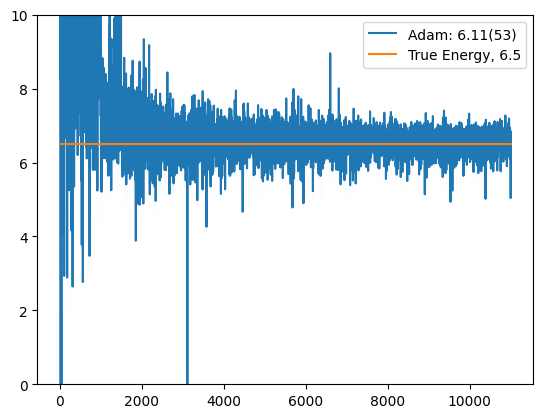

In [14]:
true_energy = 6.5

total_hists =  resultsa[0] + resultsb[0]
# + resultsc[0]  
# + resultsd[0] 
# + resultse[0]

# + resultsd[0]
total_uncerts = resultsa[1]  + resultsb[1] 
# + resultsc[1] 
# + resultsd[1] 
# + resultse[1]
# + resultsd[1]

# get index of minimum value
min_val = np.min(total_hists)
min_val = total_hists[-1]
min_index = total_hists.index(min_val)
min_err = total_uncerts[min_index]
val = gv.gvar(min_val, min_err)
fractional_error = (val - true_energy)/true_energy
print("Minimum value: ", val)
print("Fractional error: ", fractional_error)

plt.plot(np.arange(0, len(total_hists)), total_hists, label="Adam: " + str(val))
# plt.xlim(1000, 1050)
# plt.ylim(0, 10)
# plot the uncertainties
a_hists = np.array(total_hists)
a_uncerts = np.array(total_uncerts)
plt.fill_between(np.arange(0,len(total_hists)), a_hists - a_uncerts, a_hists + a_uncerts, alpha=.4)
# get the network structure
plt.plot(np.arange(0, len(total_hists)), [true_energy for x in np.arange(0, len(total_hists))], label=r"True Energy, " + str(round(true_energy,3)))
pdiff = (min_val - true_energy)/true_energy*100
# plt.annotate(" Final Percent Diff = " + str(round(pdiff,3)) + "%", xy=(.1, .9), xycoords= 'axes fraction')
plt.legend()
print(min_val)
print(min_err)
plt.show()